
To-do: 
* hyperparameter tuning
* make train its own function?
* simple correlations



_____________
# Preprocessing

In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt


import torch
import copy
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import math
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import default_collate


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [1]:
# Data Loading

#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [4]:
#@title Print Keys
print(alldat[0].keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [28]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [108]:
#@title Define Steinmetz Class
class SteinmetzSession:
  data = []
  binSize = 10
  nTrials = []
  nNeurons = []
  trialLen = 0
  trimStart = "trialStart"
  trimEnd =  "trialEnd"
  def __init__(self, dataIn):
    self.data = copy.deepcopy(dataIn)
    dims1 = np.shape(dataIn['spks'])
    self.nTrials = dims1[1]
    self.nNeurons = dims1[0]
    self.trialLen = dims1[2]

  def binData(self, binSizeIn): # Inputs: data, scalar for binning. Combines binSizeIn bins together to bin data smaller Ex. binSizeIn of 5 on the original dataset combines every 5 10 ms bins into one 50 ms bin across all trials.
    varsToRebinSum = ['spks']
    varsToRebinMean = ['wheel', 'pupil']
    spikes = self.data['spks']
    histVec = range(0,self.trialLen+1, binSizeIn)
    spikesBin = np.zeros((self.nNeurons, self.nTrials, len(histVec)))
    print(histVec)
    for trial in range(self.nTrials):
      spikes1 = np.squeeze(spikes[:,trial,:])
      for time1 in range(len(histVec)-1):
        spikesBin[:,trial, time1] = np.sum(spikes1[:, histVec[time1]:histVec[time1+1]-1], axis=1)

    spikesBin = spikesBin[:,:,:-1]
    self.data['spks'] = spikesBin
    self.trialLen = len(histVec) -1
    self.binSize = self.binSize*binSizeIn

    
    s = "Binned spikes, turning a " + repr(np.shape(spikes)) + " matrix into a " + repr(np.shape(spikesBin)) + " matrix"
    print(s)

  def plotTrial(self, trialNum): # Basic function to plot the firing rate during a single trial. Used for debugging trimming and binning
    plt.imshow(np.squeeze(self.data['spks'][:,trialNum,:]), cmap='gray_r', aspect = 'auto')
    plt.colorbar()
    plt.xlabel("Time (bins)")
    plt.ylabel("Neuron #")
    
  def realign_data_to_movement(self,length_time_in_ms): # input has to be n * nTrials * nbins
    align_time_in_bins = np.round(self.data['response_time']/self.binSize*1000)+ int(500/self.binSize) # has to add 0.5 s because the first 0.5 s is pre-stimulus
    length_time_in_bins = int(length_time_in_ms/self.binSize)
    validtrials = self.data['response']!=0
    maxtime = self.trialLen
    newshape = (self.nNeurons,self.nTrials)
    newshape+=(length_time_in_bins,)
    newdata = np.empty(newshape)
    for count,align_time_curr_trial in enumerate(align_time_in_bins):
      if (validtrials[count]==0)|(align_time_curr_trial+length_time_in_bins>maxtime) :
        validtrials[count] = 0
      else:
        newdata[:,count,:]= self.data['spks'][:,count,int(align_time_curr_trial):int(align_time_curr_trial)+length_time_in_bins]
    # newdata = newdata[:,validtrials,:]
    self.data['spks'] = newdata
    # self.validtrials = validtrials
    print('spikes aligned to movement, returning validtrials')
    return validtrials
  
  def get_areas(self):
    print(set(list(self.data['brain_area'])))

  def extractROI(self, region): #### extract neurons from single region
    rmrt=list(np.where(self.data['brain_area']!=region))[0]
    print(f' removing data from {len(rmrt)} neurons not contained in {region} ')
    self.data['spks']=np.delete(self.data['spks'],rmrt,axis=0)
    neur=len(self.data['spks'])
    print(f'neurons remaining in trial {neur}')
    self.data['brain_area']=np.delete(self.data['brain_area'],rmrt,axis=0)
    self.data['ccf']=np.delete(self.data['ccf'],rmrt,axis=0)
    
  def FlattenTs(self):
    self.data['spks']=np.hstack(self.data['spks'][:])

  def removeTrialAvgFR(self):
    mFR = self.data['spks'].mean(1)
    mFR = np.expand_dims(mFR, 1).repeat(self.data['spks'].shape[1],axis = 1)
    print(np.shape(self.data['spks']))
    print(np.shape(mFR))
    self.data['spks'] = self.data['spks'].astype(float)
    self.data['spks'] -= mFR
  def permdims(self):
    return torch.permute(torch.tensor(self.data['spks']),(2,1,0))

  def smoothFR(self, smoothingWidth):# TODO: Smooth the data and save it back to the data structure
    return 0


(977, 250)


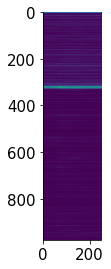

In [116]:
spks = alldat[30]['spks']
mFR = spks.mean(1)
print(mFR.shape)
plt.imshow(mFR)
plt.figure
plt.plot(mFR[0,:])
# mFR = np.expand_dims(mFR, 1).repeat(spks.shape[1],axis = 1)
# print(np.shape(spks))
# print(np.shape(mFR))
# spks = spks.astype(float)
# spks -= mFR

# print(spks.mean(1).shape)

(977, 250)


(0.0, 50.0)

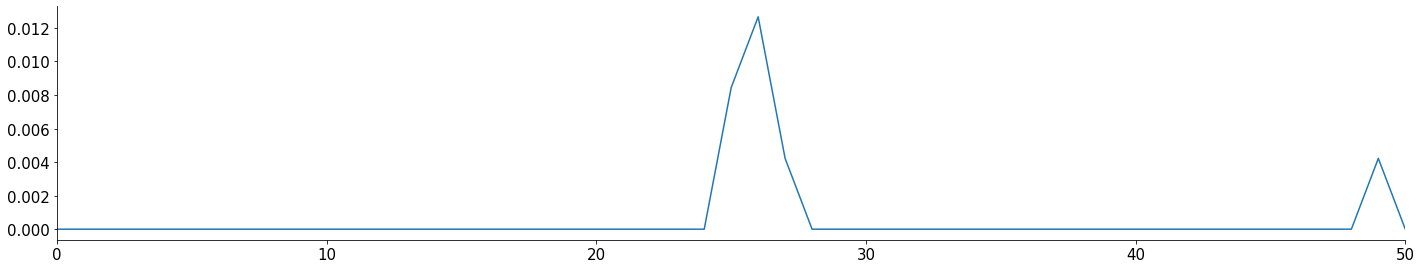

In [109]:
s31=SteinmetzSession(alldat[30])
neuron = 106
data = s31.data['spks']
mFR =  data.mean(1)
print(mFR.shape)
plt.plot(mFR[neuron,:])
plt.xlim([0,50])


(977, 237, 250)
(977, 237, 250)


(0.0, 50.0)

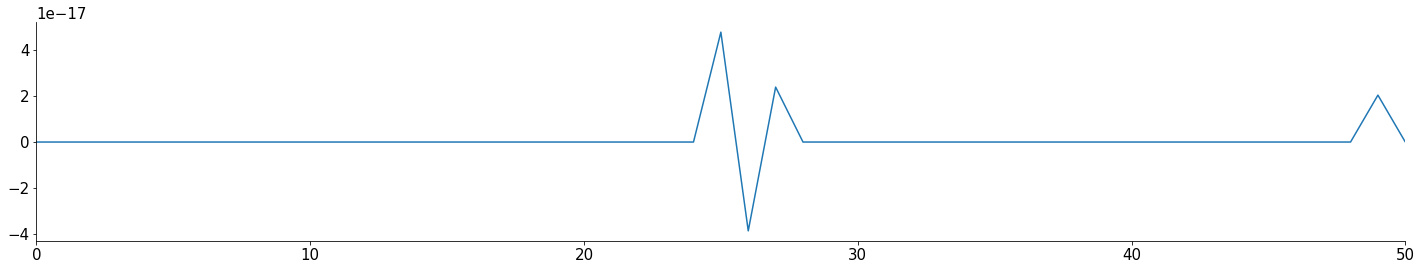

In [110]:
s31.removeTrialAvgFR()
data = s31.data['spks']
#maxN = 
#plt.plot(data[neuron,0, :])
mFR =  data.mean(1)
#print(maxFR)
plt.plot(mFR[neuron,:])
plt.xlim([0,50])

In [ ]:
#@title Set up Dataset

### dataset definition
class NeuronDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    
  def __len__(self):
    return len(self.Y)
    
  def __getitem__(self, idx):
    dataP = self.Y[idx]
    data = self.X[idx]
    sample = {"X": data, "Y": dataP}
    return sample

spikes aligned to movement, returning validtrials
(977, 237, 50)
(977, 237, 50)
{'SNr', 'CA3', 'SCm', 'OLF', 'TH', 'MOs', 'ORB', 'POST'}
 removing data from 696 neurons not contained in MOs 
neurons remaining in trial 281
torch.Size([50, 158, 281])
 removing data from 868 neurons not contained in TH 
neurons remaining in trial 109
torch.Size([50, 158, 109])


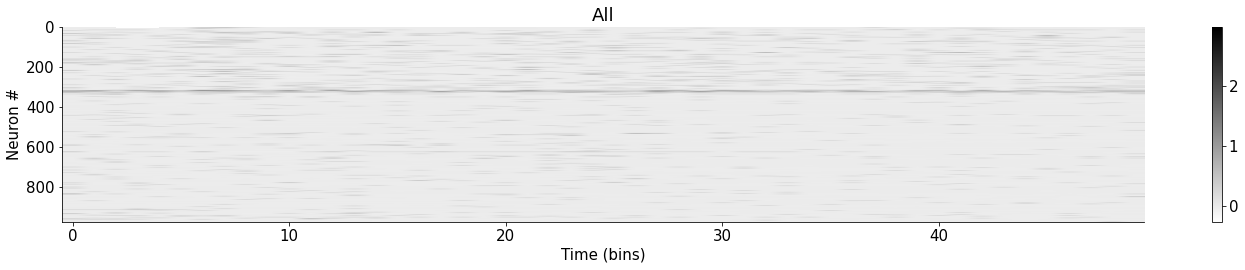

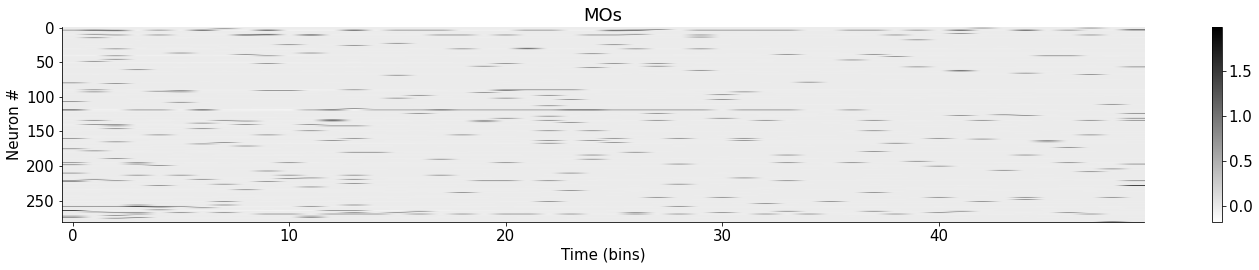

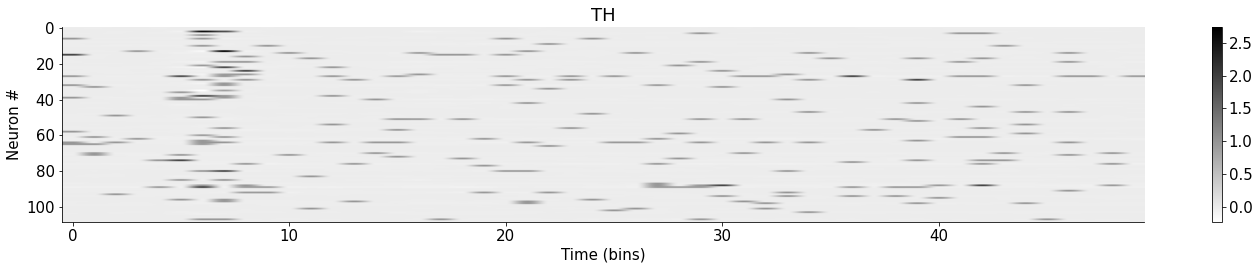

In [126]:
#@title get input for network from session 31
s31=SteinmetzSession(alldat[30])
validtrials = s31.realign_data_to_movement(500) # get 500 ms from movement time, 
s31.removeTrialAvgFR()

# cannot get realign and binning to work the same time =[

nTr = np.argwhere(validtrials) # since the other trials were defaulted to a zero value, only plot the valid trials

## plot a trial
plt.figure()
s31.plotTrial(nTr[1])
plt.title('All')

### print areas
s31.get_areas()

# s31.FlattenTs()

MO = copy.deepcopy(s31)
###remove all neurons not in motor cortex
MO.extractROI('MOs')
### plot a trial from motor neuron
plt.figure()
MO.plotTrial(nTr[1])
plt.title('MOs')
### permute the trials
MOdata = MO.permdims().float().to(device)
MOdata = MOdata[:,validtrials,:]
print(MOdata.shape)

TH = copy.deepcopy(s31)
###remove all neurons not in motor cortex
TH.extractROI('TH')
### plot a trial from motor neuron
plt.figure()
TH.plotTrial(nTr[1])
plt.title('TH')

THdata = TH.permdims().float().to(device)
THdata = THdata[:,validtrials,:]
print(THdata.shape)

In [127]:
#@title get indices for trials (split into ~60%, 30%,10%)
N = MOdata.shape[1]
np.random.seed(42)
ii = torch.randperm(N).tolist()
idx_train = ii[:math.floor(0.6*N)]
idx_val = ii[math.floor(0.6*N):math.floor(0.9*N)]
idx_test = ii[math.floor(0.9*N):]

print(N)

158


In [128]:
#@title split into train, test and validation set
x0_train = THdata[:,idx_train,:]
x0_val = THdata[:,idx_val,:]
x0_test = THdata[:,idx_test,:]

x1_train = MOdata[:,idx_train,:]
x1_val = MOdata[:,idx_val,:]
x1_test = MOdata[:,idx_test,:]

------
# DataLoader (skip for now), compatibility issue

In [ ]:
#@title Split Dataset and Create Data Loaders  
# need to make trial first so do batches in trials
batchsz= 20
ND=NeuronDataset(MOdata[:,idx_train,:],MOdata[:,idx_train,:]) 
DL_Train = DataLoader(ND, batch_size=batchsz)

ND=NeuronDataset(MOdata[:,idx_val,:],MOdata[:,idx_val,:]) 
DL_Val = DataLoader(ND, batch_size=batchsz)

ND=NeuronDataset(MOdata[:,idx_test,:],MOdata[:,idx_test,:]) 
DL_Test = DataLoader(ND, batch_size=batchsz)

In [ ]:
#### check that the data loader is iterating correctly 
print('\nFirst iteration of data set: ', next(iter(DL_Train)), '\n')
print('Length of data set: ', len(DL_Train), '\n')


First iteration of data set:  {'X': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ...

In [ ]:
# time * trial * neuron
next(iter(DL_Train))['X'].shape
next(iter(DL_Train))['Y'].shape

torch.Size([20, 94, 281])

---------
# Model

In [156]:
class Net(nn.Module): # our model
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn1 = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0, # MO
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.rnn2 = nn.RNN(NN2,ncomp,num_layers = 1, dropout = 0, bidirectional = bidi, nonlinearity = 'tanh') #TH

    if bidi == True:
      self.fclatent = nn.Linear(ncomp*2,ncomp*2)
    else: 
      self.fclatent = nn.Linear(ncomp,ncomp)

    self.fc = nn.Linear(ncomp,NN1)

  def forward(self, x0,x1):
    y2 = self.rnn2(x0)[0] # ncomp TH
    y =  self.rnn1(x1)[0] # ncomp MOs
    y += self.fclatent(y2) # ncomp MOs with projection of latent TH components

    if self.rnn1.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

In [219]:
#@title Set input/hyperparameters here:
ncomp = 10
NN1 = MOdata.shape[2]
print(NN1)
NN2 = THdata.shape[2]
print(NN2)

learning_rate_start = 0.002


281
109


In [220]:
#@title first the basic network with MO => MO (no external input)

net_baseline = Net(ncomp, NN1, NN2, bidi = True).to(device)
net_baseline.fclatent.weight.data[:] = 0 # fixed weights =0 so the TH input is not considered
net_baseline.fclatent.bias.data[:] = 0
net_baseline.fclatent.weight.requires_grad = False
net_baseline.fclatent.bias.requires_grad = False

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
# net_baseline.fc.bias.data[:] = MOdata.mean((0,1))

# we set up the optimizer later in the training loop

print(net_baseline)

Net(
  (rnn1): RNN(281, 10, bidirectional=True)
  (rnn2): RNN(109, 10, bidirectional=True)
  (fclatent): Linear(in_features=20, out_features=20, bias=True)
  (fc): Linear(in_features=10, out_features=281, bias=True)
)


In [221]:
#@title train net_baseline
'''
you can keep re-running this cell if you think the cost might decrease further
x1_train = input we are predicting (MOs)
x0_train = input from other areas (e.g. TH)
'''
# we define the Poisson log-likelihood loss
# def Poisson_loss(lam, spk):
#   return lam - spk * torch.log(lam)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net_baseline.parameters(), lr=learning_rate_start)

set_seed(seed=2021)

niter = 1000
training_cost = []
val_cost = []
for k in range(niter):
  ### training
  optimizer.zero_grad()
  # the network outputs the single-neuron prediction and the latents
  z, y = net_baseline(x0_train,x1_train)
  cost = loss(z,x1_train).mean()
  # # our log-likelihood cost
  # cost = Poisson_loss(z, x1_train).mean()
  # train the network as usual
  cost.backward()
  optimizer.step()
  training_cost.append(cost.item())

  ### test on validation data
  z_val,_ = net_baseline(x0_val,x1_val)
  cost = loss(z_val,x1_val).mean()
  # cost = Poisson_loss(z_val, x1_val).mean()
  val_cost.append(cost.item())

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')

Random seed 2021 has been set.
iteration 0, cost 0.0510
iteration 100, cost 0.0182
iteration 200, cost 0.0154
iteration 300, cost 0.0138
iteration 400, cost 0.0131
iteration 500, cost 0.0126
iteration 600, cost 0.0124
iteration 700, cost 0.0122
iteration 800, cost 0.0121
iteration 900, cost 0.0120


Text(0.5, 0, 'epochs')

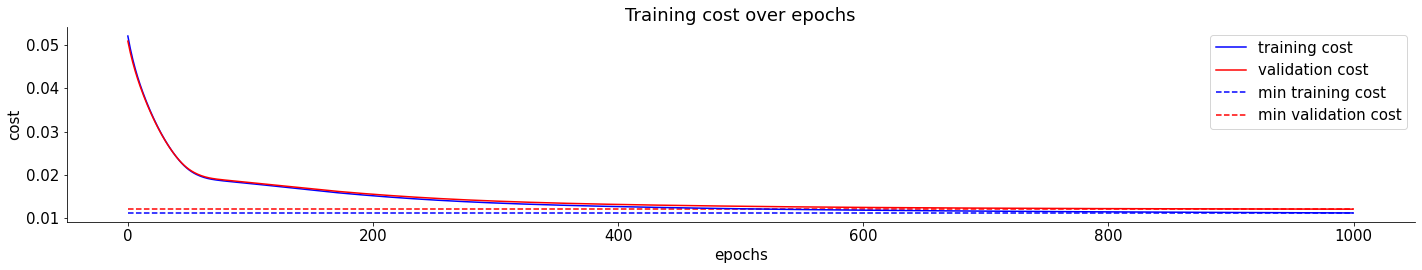

In [222]:
#@title Plot training progress
plt.plot(training_cost,'b')
plt.plot(val_cost,'r')
plt.hlines(np.min(training_cost),0,niter,'b',linestyles = '--')
plt.hlines(np.min(val_cost),0,niter,'r',linestyles = '--')

plt.legend(['training cost','validation cost','min training cost','min validation cost'])
plt.title('Training cost over epochs')
plt.ylabel('cost')
plt.xlabel('epochs')

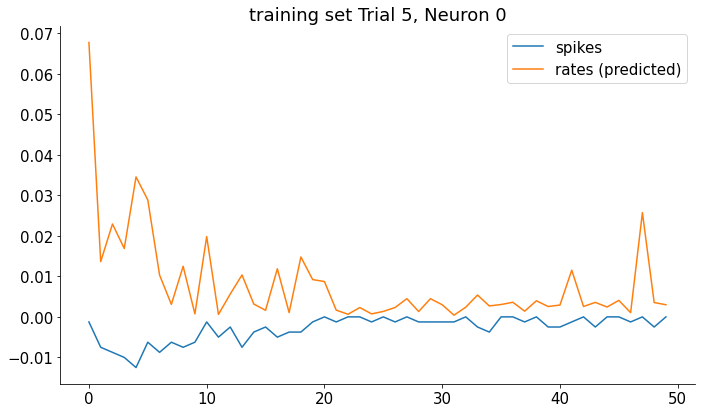

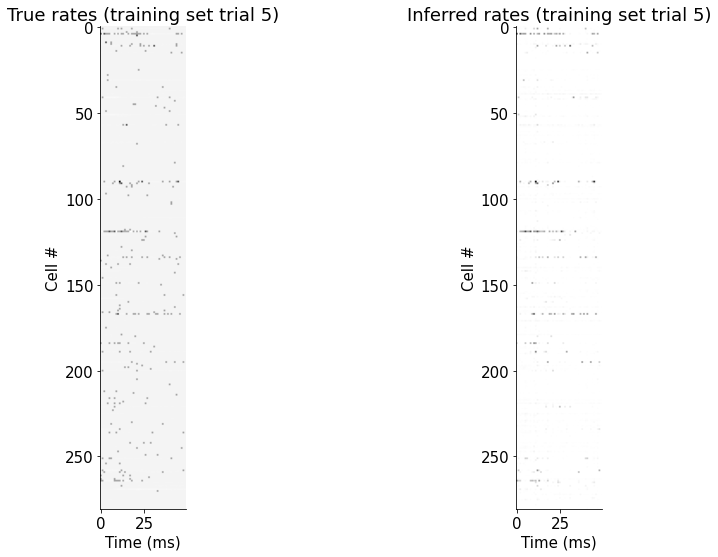

In [223]:
#@title Plot performance on training data
rpred = z.detach().cpu().numpy()
rates = x1_train

nTr = 5
nNeuron = 0
plt.figure(figsize=(10, 6))
plt.plot(rates[:,nTr, nNeuron])
plt.plot(rpred[:,nTr, nNeuron])

plt.legend(['spikes', 'rates (predicted)'])
plt.title(f'training set Trial {nTr}, Neuron {nNeuron}')
plt.show()

plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(rates[:, nTr, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'True rates (training set trial {nTr})')

plt.subplot(122)
plt.imshow(rpred[:, nTr, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'Inferred rates (training set trial {nTr})')
plt.show()

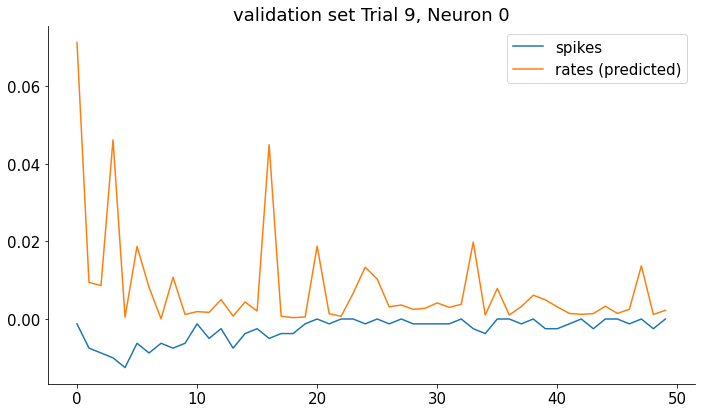

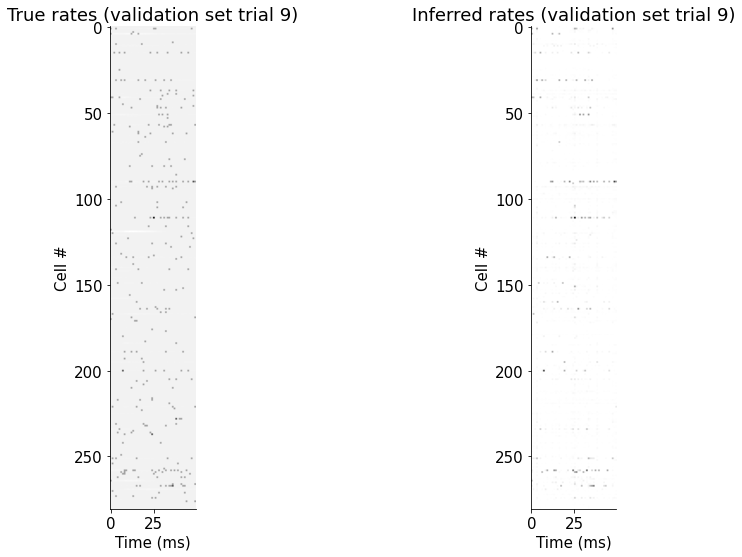

In [224]:
#@title Performance on validation data
rpred = z_val.detach().cpu().numpy()
rates = x1_val

nTr = 9
nNeuron = 0
plt.figure(figsize=(10, 6))
plt.plot(rates[:,nTr, nNeuron])
plt.plot(rpred[:,nTr, nNeuron])

plt.legend(['spikes', 'rates (predicted)'])
plt.title(f'validation set Trial {nTr}, Neuron {nNeuron}')
plt.show()

plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(rates[:, nTr, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'True rates (validation set trial {nTr})')

plt.subplot(122)
plt.imshow(rpred[:, nTr, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'Inferred rates (validation set trial {nTr})')
plt.show()

In [227]:
# save model (first on colab environment but you can download it, see <https://neptune.ai/blog/google-colab-dealing-with-files>)
PATH = 'steinmetz_model_baseline.pt'
torch.save(net_baseline.state_dict(), PATH) 
del net_baseline

# to prevent further training net_baseline, we are going to start from loading the model directly from now on.

In [235]:
 # load saved model
net_baseline = Net(ncomp, NN1, NN2, bidi = True).to(device)
net_baseline.load_state_dict(torch.load('steinmetz_model_baseline.pt'))

<All keys matched successfully>

In [237]:
# after training the baseline network, get the weights of rnn1 and freeze it
net_withinput  = copy.deepcopy(net_baseline)

net_withinput.fclatent.weight.requires_grad = True
net_withinput.fclatent.bias.requires_grad = True

# # set weight initalization to random
net_withinput.fclatent.reset_parameters()


net_withinput.rnn1.weight_ih_l0.requires_grad = False
net_withinput.rnn1.weight_hh_l0.requires_grad = False
net_withinput.rnn1.bias_ih_l0.requires_grad = False
net_withinput.rnn1.bias_hh_l0.requires_grad = False
net_withinput.rnn1.weight_ih_l0_reverse.requires_grad = False
net_withinput.rnn1.weight_hh_l0_reverse.requires_grad = False
net_withinput.rnn1.bias_ih_l0_reverse.requires_grad = False
net_withinput.rnn1.bias_hh_l0_reverse.requires_grad = False
    
print(net_withinput)

Net(
  (rnn1): RNN(281, 10, bidirectional=True)
  (rnn2): RNN(109, 10, bidirectional=True)
  (fclatent): Linear(in_features=20, out_features=20, bias=True)
  (fc): Linear(in_features=10, out_features=281, bias=True)
)


In [238]:
#@title train net_withinput
'''
you can keep re-running this cell if you think the cost might decrease further
x1_train = input we are predicting (MOs)
x0_train = input from other areas (e.g. TH)
'''
# we define the Poisson log-likelihood loss
# def Poisson_loss(lam, spk):
#   return lam - spk * torch.log(lam)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net_withinput.parameters(), lr=learning_rate_start) # this is very important

set_seed(seed=2021)

niter = 1000
training_cost = []
val_cost = []
for k in range(niter):
  ### training
  optimizer.zero_grad()
  # the network outputs the single-neuron prediction and the latents
  z, y = net_withinput(x0_train,x1_train)
  # our log-likelihood cost
  cost = loss(z, x1_train).mean()
  # train the network as usual
  cost.backward()
  optimizer.step()
  training_cost.append(cost.item())

  ### test on validation data
  z_val,_ = net_withinput(x0_val,x1_val)
  cost = loss(z_val, x1_val).mean()
  val_cost.append(cost.item())

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')

Random seed 2021 has been set.
iteration 0, cost 0.0173
iteration 100, cost 0.0121
iteration 200, cost 0.0120
iteration 300, cost 0.0120
iteration 400, cost 0.0120
iteration 500, cost 0.0120
iteration 600, cost 0.0121
iteration 700, cost 0.0121
iteration 800, cost 0.0121
iteration 900, cost 0.0122


Text(0.5, 0, 'epochs')

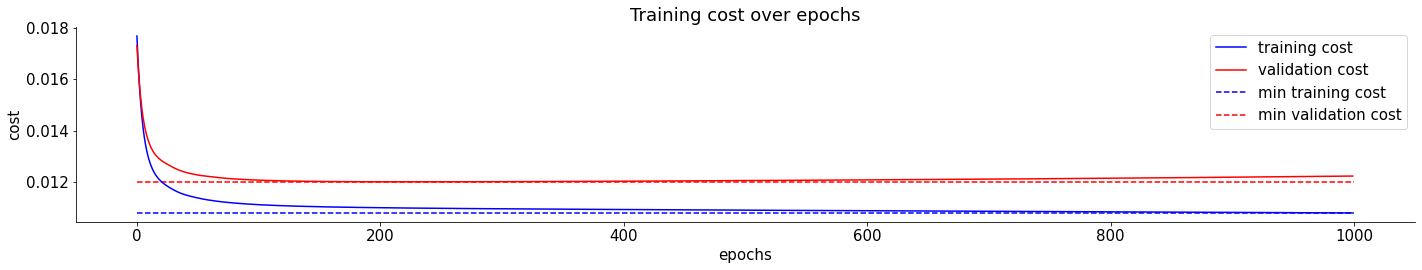

In [239]:
#@title Plot training progress
plt.plot(training_cost,'b')
plt.plot(val_cost,'r')
plt.hlines(np.min(training_cost),0,niter,'b',linestyles = '--')
plt.hlines(np.min(val_cost),0,niter,'r',linestyles = '--')

plt.legend(['training cost','validation cost','min training cost','min validation cost'])
plt.title('Training cost over epochs')
plt.ylabel('cost')
plt.xlabel('epochs')

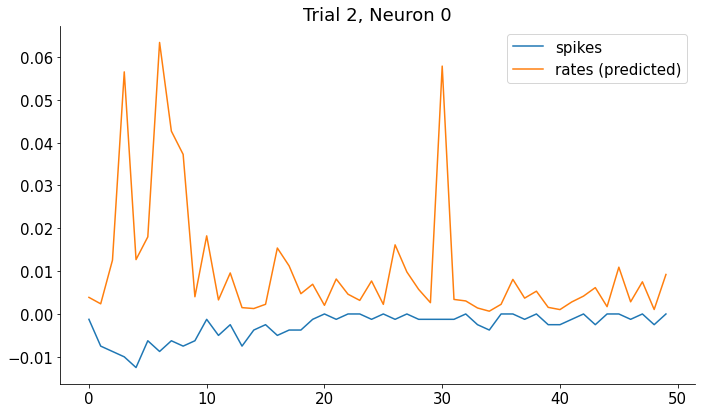

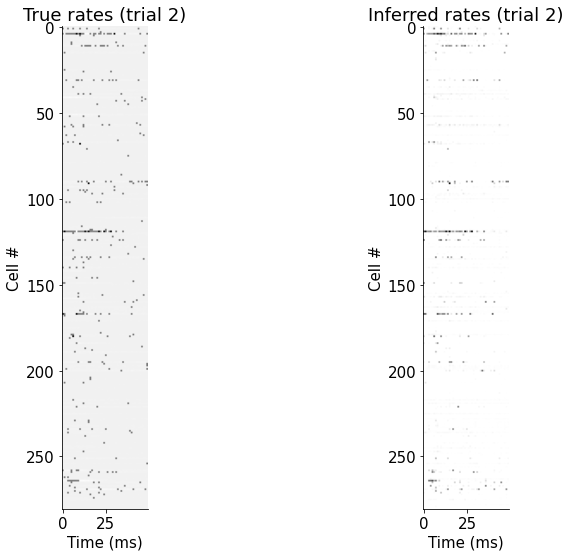

In [240]:
#@title Plot performance on training data
rpred = z.detach().cpu().numpy()
rates = x1_train

nTr = 2
nNeuron = 0
plt.figure(figsize=(10, 6))
plt.plot(rates[:,nTr, nNeuron])
plt.plot(rpred[:,nTr, nNeuron])

plt.legend(['spikes', 'rates (predicted)'])
plt.title(f'Trial {nTr}, Neuron {nNeuron}')
plt.show()

plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(rates[:, nTr, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'True rates (trial {nTr})')

plt.subplot(122)
plt.imshow(rpred[:, nTr, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'Inferred rates (trial {nTr})')
plt.show()

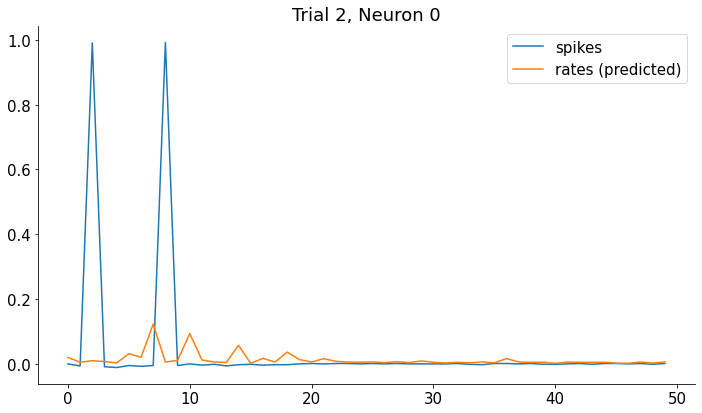

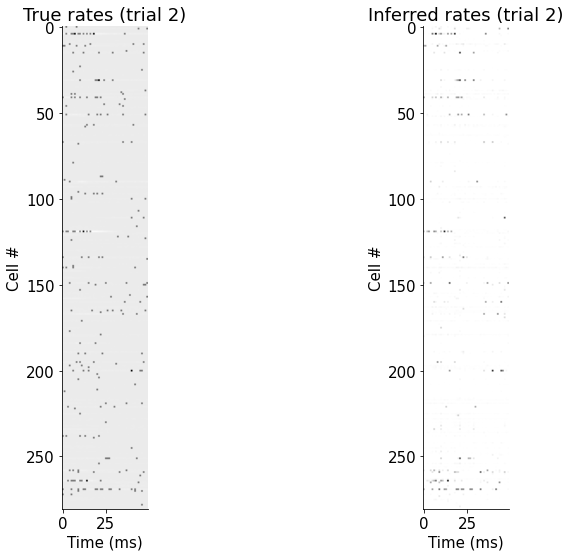

In [241]:
#@title Performance on validation data
rpred = z_val.detach().cpu().numpy()
rates = x1_val

nTr = 2
nNeuron = 0
plt.figure(figsize=(10, 6))
plt.plot(rates[:,nTr, nNeuron])
plt.plot(rpred[:,nTr, nNeuron])

plt.legend(['spikes', 'rates (predicted)'])
plt.title(f'Trial {nTr}, Neuron {nNeuron}')
plt.show()

plt.figure(figsize = (12, 8))
plt.subplot(121)
plt.imshow(rates[:, nTr, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'True rates (trial {nTr})')

plt.subplot(122)
plt.imshow(rpred[:, nTr, :].T, cmap='gray_r')
plt.xlabel('Time (ms)')
plt.ylabel('Cell #')
plt.title(f'Inferred rates (trial {nTr})')
plt.show()

#compare with just training the previous network for another 100 epochs

In [242]:
#@title train net_baseline
'''
you can keep re-running this cell if you think the cost might decrease further
x1_train = input we are predicting (MOs)
x0_train = input from other areas (e.g. TH)
'''
# we define the Poisson log-likelihood loss
# def Poisson_loss(lam, spk):
#   return lam - spk * torch.log(lam)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net_baseline.parameters(), lr=learning_rate_start)
set_seed(seed=2021)

niter = 100
training_cost = []
val_cost = []
for k in range(niter):
  ### training
  optimizer.zero_grad()
  # the network outputs the single-neuron prediction and the latents
  z, y = net_baseline(x0_train,x1_train)
  cost = loss(z,x1_train).mean()
  # # our log-likelihood cost
  # cost = Poisson_loss(z, x1_train).mean()
  # train the network as usual
  cost.backward()
  optimizer.step()
  training_cost.append(cost.item())

  ### test on validation data
  z_val,_ = net_baseline(x0_val,x1_val)
  cost = loss(z_val,x1_val).mean()
  # cost = Poisson_loss(z_val, x1_val).mean()
  val_cost.append(cost.item())

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')

Random seed 2021 has been set.
iteration 0, cost 0.0120


Text(0.5, 0, 'epochs')

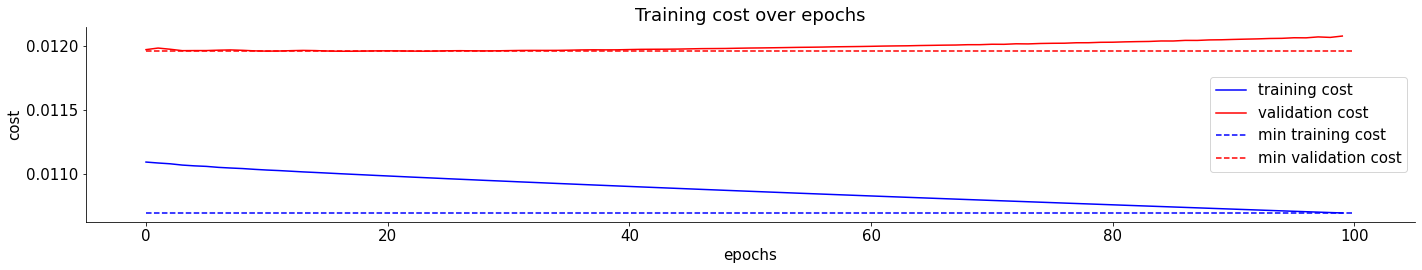

In [243]:
#@title Plot training progress
plt.plot(training_cost,'b')
plt.plot(val_cost,'r')
plt.hlines(np.min(training_cost),0,niter,'b',linestyles = '--')
plt.hlines(np.min(val_cost),0,niter,'r',linestyles = '--')

plt.legend(['training cost','validation cost','min training cost','min validation cost'])
plt.title('Training cost over epochs')
plt.ylabel('cost')
plt.xlabel('epochs')

In [244]:
#@title what if we don't freeze the weights

# after training the baseline network, get the weights of rnn1 and freeze it
net_withinput2  = copy.deepcopy(net_baseline)

net_withinput2.fclatent.weight.requires_grad = True
net_withinput2.fclatent.bias.requires_grad = True

# # set weight initalization to random
net_withinput2.fclatent.reset_parameters()

print(net_withinput2)

Net(
  (rnn1): RNN(281, 10, bidirectional=True)
  (rnn2): RNN(109, 10, bidirectional=True)
  (fclatent): Linear(in_features=20, out_features=20, bias=True)
  (fc): Linear(in_features=10, out_features=281, bias=True)
)


In [245]:
#@title train net_baseline
'''
you can keep re-running this cell if you think the cost might decrease further
x1_train = input we are predicting (MOs)
x0_train = input from other areas (e.g. TH)
'''
# we define the Poisson log-likelihood loss
# def Poisson_loss(lam, spk):
#   return lam - spk * torch.log(lam)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net_withinput2.parameters(), lr=learning_rate_start)
set_seed(seed=2021)

niter = 1000
training_cost = []
val_cost = []
for k in range(niter):
  ### training
  optimizer.zero_grad()
  # the network outputs the single-neuron prediction and the latents
  z, y = net_withinput2(x0_train,x1_train)
  cost = loss(z,x1_train).mean()
  # # our log-likelihood cost
  # cost = Poisson_loss(z, x1_train).mean()
  # train the network as usual
  cost.backward()
  optimizer.step()
  training_cost.append(cost.item())

  ### test on validation data
  z_val,_ = net_withinput2(x0_val,x1_val)
  cost = loss(z_val,x1_val).mean()
  # cost = Poisson_loss(z_val, x1_val).mean()
  val_cost.append(cost.item())

  if k % 100 == 0:
    print(f'iteration {k}, cost {cost.item():.4f}')

Random seed 2021 has been set.
iteration 0, cost 0.0339
iteration 100, cost 0.0124
iteration 200, cost 0.0122
iteration 300, cost 0.0121
iteration 400, cost 0.0121
iteration 500, cost 0.0121
iteration 600, cost 0.0121
iteration 700, cost 0.0121
iteration 800, cost 0.0122
iteration 900, cost 0.0122


Text(0.5, 0, 'epochs')

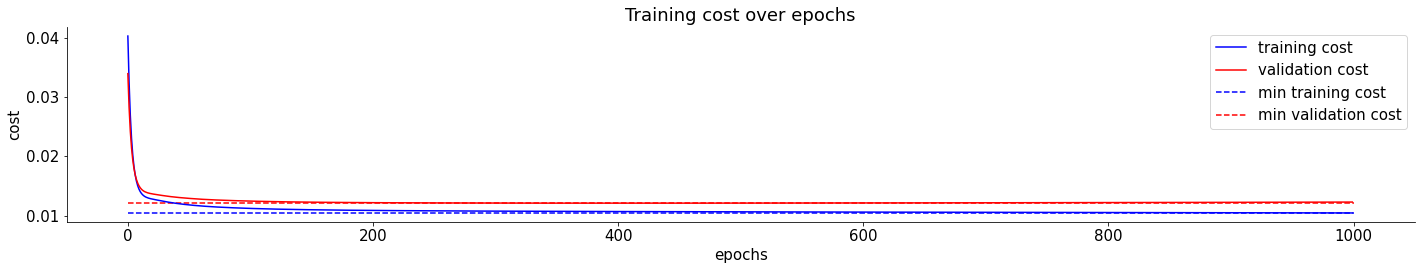

In [246]:
#@title Plot training progress
plt.plot(training_cost,'b')
plt.plot(val_cost,'r')
plt.hlines(np.min(training_cost),0,niter,'b',linestyles = '--')
plt.hlines(np.min(val_cost),0,niter,'r',linestyles = '--')

plt.legend(['training cost','validation cost','min training cost','min validation cost'])
plt.title('Training cost over epochs')
plt.ylabel('cost')
plt.xlabel('epochs')

--------------------- The end -------------------


--------------------------
# Below are some old stuff

In [ ]:
for (idx, batch) in enumerate(DL_DS):
  pass
      # print(idx, 'X:', batch['X'])

In [ ]:
#Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 100

# Datasets
partition = # IDs
labels = # Labels

# Generators
training_set = Dataset(partition['train'], labels)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

SyntaxError: ignored

In [ ]:
import torch

# @title Set device (GPU or CPU). Execute `set_device()`

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device



device = set_device()


GPU is enabled in this notebook.


In [ ]:
# set the seed
np.random.seed(42)

# 100 trials is typical of neural data
ntrials = 100

# we simulate 200 neurons
NN = 200

# we will pretend like every "bin" is 10ms, so the trial length is 2500ms
NT = 250

# let's use 10 latent components
ncomp = 10

# this is the recurrent dynamics matrix, which we made diagonal for simplicity
# values have to be smaller than 1 for stability
A0 =  np.diag(.8 + .2 * np.random.rand(ncomp,))

# this is the projection matrix from components to neurons
C0 = .025 * np.random.randn(ncomp, NN)

# We generate the dynamics of the low-d system. We initialize the latent state.

# start by initializing the latents
y       = 2 * np.random.randn(ncomp)
latents = np.zeros((NT, ntrials, ncomp))
# we run the dynamics forward and add noise (or "innovations") at each timestep
for t in range(NT):
  y = y @ A0 +  np.random.randn(ntrials, ncomp)
  latents[t] = y

# we now project the latents to the neuron space and threshold to generate firing rates
rates = np.maximum(0, latents @ C0)

# now we draw poisson counts to simulate the number of spikes a neuron fires randomly
x = np.random.poisson(rates)
x0 = torch.from_numpy(x[:, :, :200]).to(device).float()
x1 = torch.from_numpy(x[:, :, 200:]).to(device).float()

x0 = torch.permute(x0, (2,1,0))
x0 = np.reshape(x0, (-1,200))


x1 = torch.permute(x1, (2,1,0))
x1 = np.reshape(x1, (-1,200))
print(x1.shape)


TypeError: ignored

In [ ]:
import torch
import torch.nn as nn
import torchvision 
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(np.shape(x0))

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=200).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

torch.Size([25000, 200])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torchvision.datasets.mnist.MNIST

In [ ]:
epochs = 100
for epoch in range(epochs):
    loss = 0

    # reshape mini-batch data to [N, 784] matrix
    # load it to the active device
    
    # reset the gradients back to zero
    # PyTorch accumulates gradients on subsequent backward passes
    optimizer.zero_grad()
    
    # compute reconstructions
    print(type(x0))
    outputs = model(x0)
    
    # compute training reconstruction loss
    train_loss = criterion(outputs, x0)
    
    # compute accumulated gradients
    train_loss.backward()
    
    # perform parameter update based on current gradients
    optimizer.step()
    
    # add the mini-batch training loss to epoch loss
    loss += train_loss.item()
    

    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

<class 'torch.Tensor'>
epoch : 1/100, loss = 0.114980
<class 'torch.Tensor'>
epoch : 2/100, loss = 0.114161
<class 'torch.Tensor'>
epoch : 3/100, loss = 0.113437
<class 'torch.Tensor'>
epoch : 4/100, loss = 0.112906
<class 'torch.Tensor'>
epoch : 5/100, loss = 0.112515
<class 'torch.Tensor'>
epoch : 6/100, loss = 0.112154
<class 'torch.Tensor'>
epoch : 7/100, loss = 0.111754
<class 'torch.Tensor'>
epoch : 8/100, loss = 0.111305
<class 'torch.Tensor'>
epoch : 9/100, loss = 0.110838
<class 'torch.Tensor'>
epoch : 10/100, loss = 0.110377
<class 'torch.Tensor'>
epoch : 11/100, loss = 0.109895
<class 'torch.Tensor'>
epoch : 12/100, loss = 0.109346
<class 'torch.Tensor'>
epoch : 13/100, loss = 0.108746
<class 'torch.Tensor'>
epoch : 14/100, loss = 0.108141
<class 'torch.Tensor'>
epoch : 15/100, loss = 0.107535
<class 'torch.Tensor'>
epoch : 16/100, loss = 0.106912
<class 'torch.Tensor'>
epoch : 17/100, loss = 0.106286
<class 'torch.Tensor'>
epoch : 18/100, loss = 0.105669
<class 'torch.Tenso

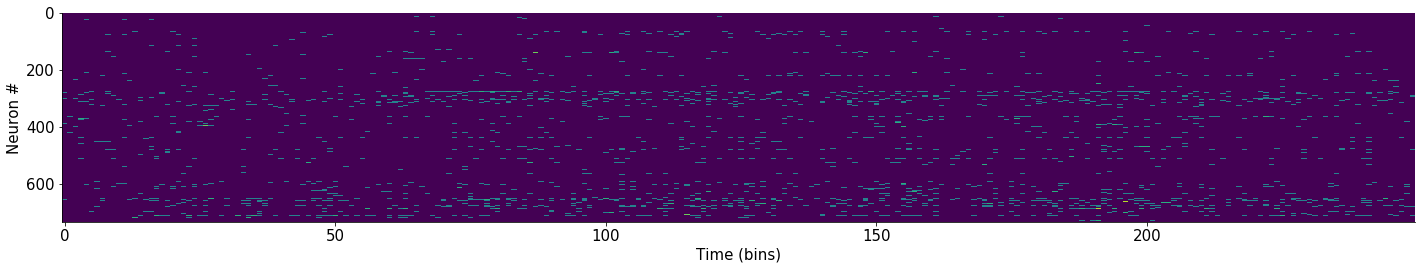

In [ ]:
s1.plotTrial(1)


range(0, 251, 10)
Binned spikes, turning a (734, 214, 250) matrix into a (734, 214, 25) matrix


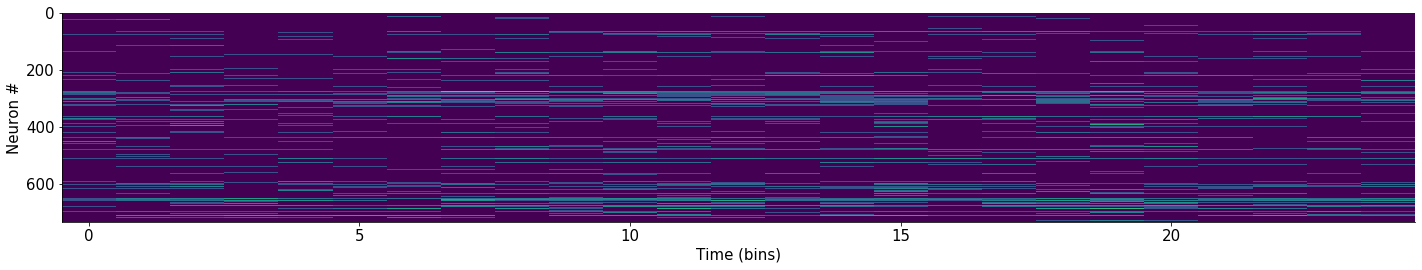

In [ ]:
s1.binData(10)
s1.plotTrial(1)